# A Toy Reinforcement Learning Ad Recommender System

### References
* https://github.com/yeshwanthv5/rl-playground/blob/master/notebooks/exploration_in_bandit_algorithms.ipynb
* https://github.com/conormm/bandit_algorithms/blob/master/bandits_post_code.py
* https://towardsdatascience.com/solving-multiarmed-bandits-a-comparison-of-epsilon-greedy-and-thompson-sampling-d97167ca9a50

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta
from matplotlib import rc

In [2]:
class User:
    def __init__(self, uid, name = "User_"):
        self.uid = uid
        if name == "User_":
            self.name = name + str(uid) # Create a synthetic name if no name is given
        else:
            self.name = name
    def __repr__(self):
        return "User()"
    
    def __str__(self):
        return "User -- \n uid: {}, name: {}".format(self.uid, self.name)

In [3]:
u1 = User(1)
print(u1)

User -- 
 uid: 1, name: User_1


In [4]:
class Item:
    def __init__(self, item_id, name = "Item_", relevance_score=0.0):
        self.item_id = item_id
        if name == "Item_":
            self.name = name + str(item_id) # Create a synthetic name if no name is given
        else:
            self.name = name
        if relevance_score == 0.0:
            self.relevance_score = np.random.uniform(0,1) # Assign a random relevance score if no relevance is given
        else:
            self.relevance_score = relevance_score
        self.num_clicks = 0
        self.is_ad = False
        self.ad_clicks = 0
        self.boost_score = 0.0
        self.recent_boost = self.relevance_score
    
    """ Function to simulate clicks """
    # Later: Use user parameters
    def click(self, user, sr):
        self.num_clicks += 1
        if self.is_ad == True:
            self.ad_clicks += 1
            sr.update(1, self)
            
    def noclick(self, user, sr):
        if self.is_ad == True:
            sr.update(-1, self)
    
    """ Make an item as sponsored """
    def make_ad(self):
        self.is_ad = True
        self.boost_score = 0.1
    
    """ Remove an item from the sponsored list """
    def remove_ad(self):
        self.is_ad = False
        self.boost_score = 0.0
        self.ad_clicks = 0 # Reset ad clicks

    def __repr__(self):
        return "Item()"
    
    def __str__(self):
        return "Item --- \n item_id: {}, name: {}, relevance_score: {:.2f}, num_clicks: {}, is_ad: {}, ad_clicks: {}, boost_score: {:.2f}, boosted_relevance: {:.2f}".format(
        self.item_id, self.name, self.relevance_score, self.num_clicks, self.is_ad, self.ad_clicks, self.boost_score, (1 + self.boost_score) * self.relevance_score if self.is_ad == True else self.relevance_score)

In [5]:
class search_results:
    def __init__(self, item_inventory = [], epsilon = 0.5, lr_positive = 0.005, lr_negative = 0.0005):
        self.item_inventory = item_inventory # List of items in the inventory
        self.epsilon = epsilon
        self.lr_positive = lr_positive
        self.lr_negative = lr_negative
        
    def add_item(self, item):
        self.item_inventory.append(item) # Add new item to the inventory
        
    def get_organic_results(self): # Ranking algo
        self.item_inventory.sort(key = lambda x: x.relevance_score, reverse = True)
        return self.item_inventory
    
    def get_results_with_ads(self): # Modified ranking algo with ads getting boosted
        for item in self.item_inventory:
            item.recent_boost = (item.relevance_score * (1 + np.random.uniform(0,0.5)) if np.random.uniform() < self.epsilon else item.relevance_score * (1 + item.boost_score) ) if (item.is_ad == True) else item.relevance_score
        self.item_inventory.sort(key = lambda x: x.recent_boost, reverse = True)
        return self.item_inventory

    def update(self, reward, item):
        if reward == 1: # Ad recieved a click
            item.boost_score = min(self.lr_positive + item.boost_score, 0.5)
        else: # Did not get a click
            item.boost_score = max(item.boost_score - self.lr_negative, 0)

In [6]:
sr = search_results()

In [7]:
# Test Item
item1 = Item(1, "Parle-G", 0.6)
print(item1)
item1.click(u1, sr)
print(item1)
item1.make_ad()
print(item1)
item1.click(u1, sr)
print(item1)

Item --- 
 item_id: 1, name: Parle-G, relevance_score: 0.60, num_clicks: 0, is_ad: False, ad_clicks: 0, boost_score: 0.00, boosted_relevance: 0.60
Item --- 
 item_id: 1, name: Parle-G, relevance_score: 0.60, num_clicks: 1, is_ad: False, ad_clicks: 0, boost_score: 0.00, boosted_relevance: 0.60
Item --- 
 item_id: 1, name: Parle-G, relevance_score: 0.60, num_clicks: 1, is_ad: True, ad_clicks: 0, boost_score: 0.10, boosted_relevance: 0.66
Item --- 
 item_id: 1, name: Parle-G, relevance_score: 0.60, num_clicks: 2, is_ad: True, ad_clicks: 1, boost_score: 0.11, boosted_relevance: 0.66


In [8]:
num_items = 20
for i in range(num_items):
    item = Item(i)
    if(i%4 == 0):
        item.make_ad()
    sr.add_item(item)

In [9]:
def printresults(results):
    item_ids = []
    relevance_scores = []
    boost_scores = []
    recent_boosts = []
    for item in results:
        # print(item)
        item_ids.append(item.item_id)
        relevance_scores.append(item.relevance_score)
        boost_scores.append(item.relevance_score*item.boost_score)
        recent_boosts.append(item.recent_boost)
    rc('font', weight='bold')
    bars1 = relevance_scores
    bars2 = boost_scores
    bars3 = recent_boosts
    ind = np.arange(len(item_ids))
    r = [i for i in range(len(item_ids))]
    r2 = [i for i in range(len(item_ids))]
    names = item_ids
    barWidth = .3
    # Create brown bars
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(ind, bars1, barWidth, edgecolor='white')
    # Create green bars (middle), on top of the firs ones
    ax.barh(ind, bars2, barWidth, left=bars1, edgecolor='white')
    ax.barh(ind + barWidth, bars3, barWidth, edgecolor='white', color='silver')
    ax.set(yticks=ind + barWidth, yticklabels=item_ids, ylim=[2*barWidth - 1, len(item_ids)])
    ax.legend(['Organic Relevance','Ad Boost','Weight used for ranking (Considering exploration)'])
    # Show graphic
    plt.show()

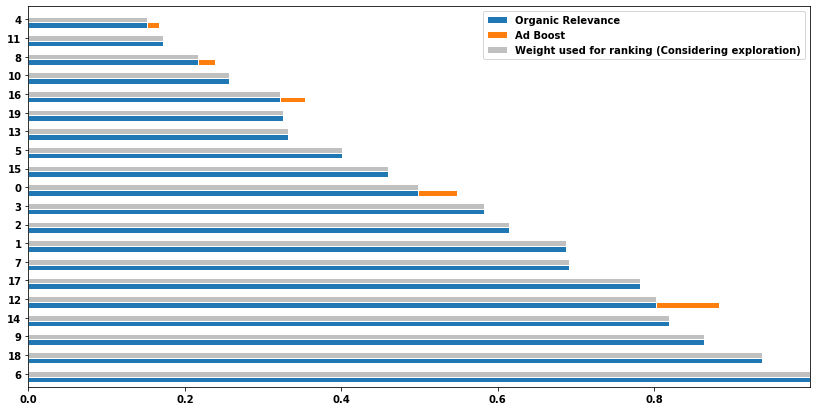

In [10]:
printresults(sr.get_organic_results())

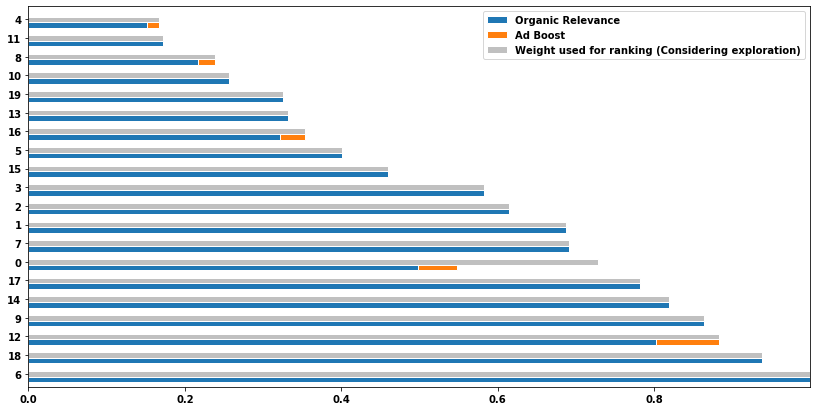

In [11]:
printresults(sr.get_results_with_ads())

In [12]:
def simulate_clicks(sr):
    results = sr.get_results_with_ads()
    click_prob = 0.5
    for item in results:
        if np.random.uniform() < click_prob:
            item.click(u1, sr)
        else:
            item.noclick(u1, sr)
        click_prob = click_prob*0.8



Results after 100 iterations -------


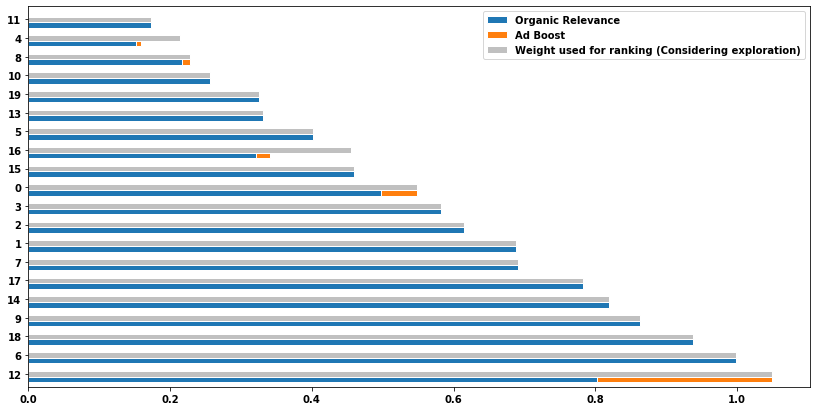



Results after 200 iterations -------


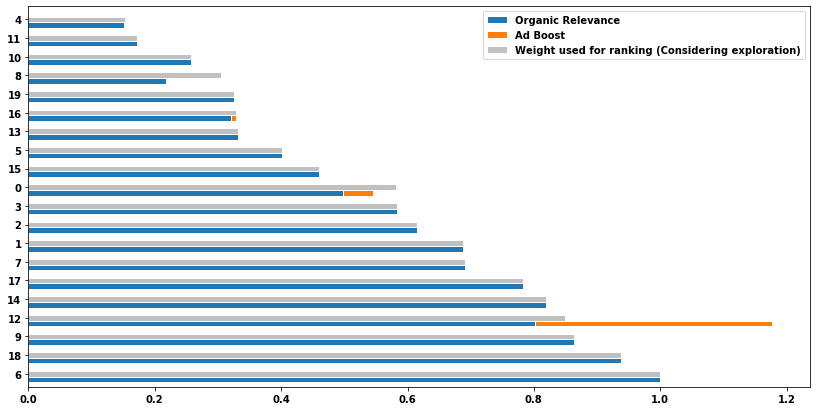



Results after 300 iterations -------


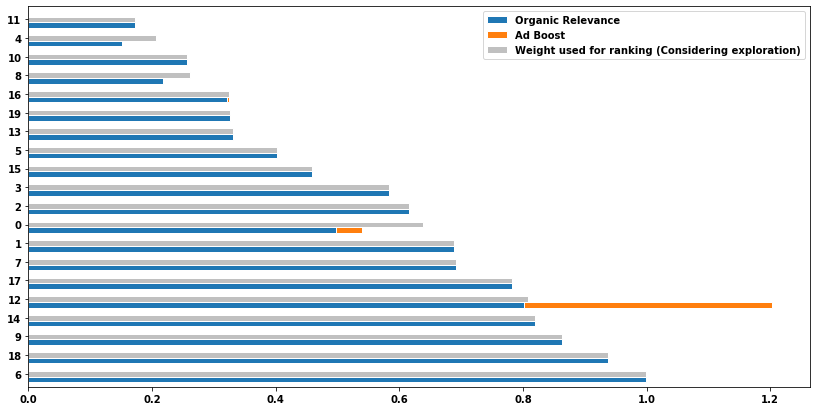



Results after 400 iterations -------


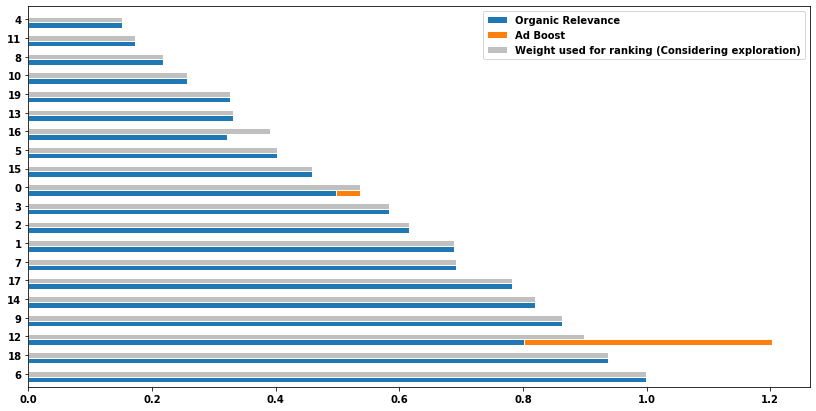



Results after 500 iterations -------


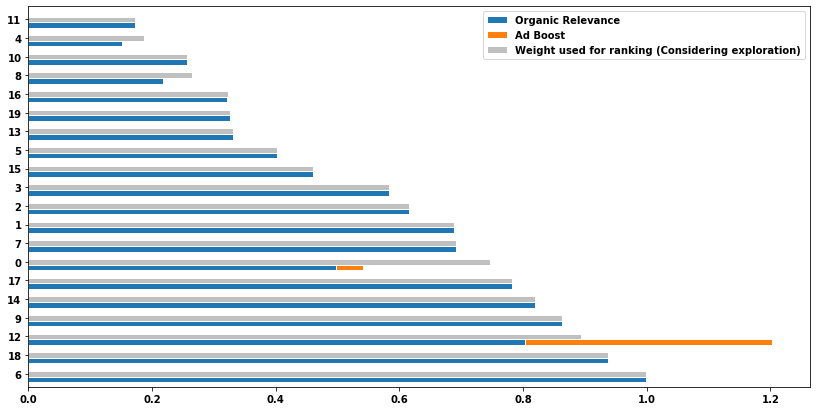



Results after 600 iterations -------


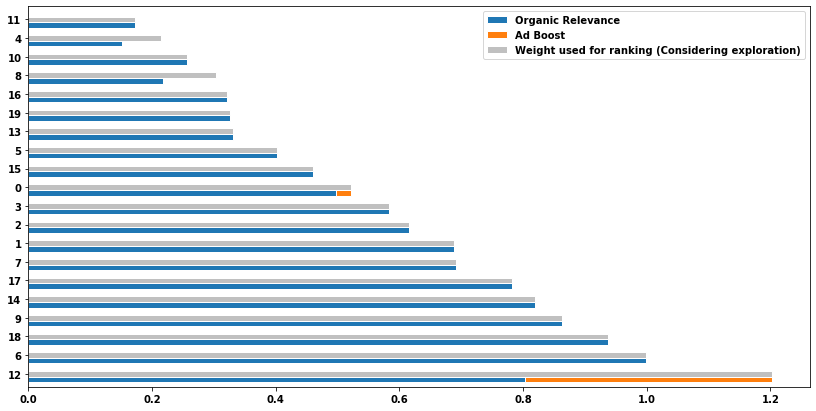



Results after 700 iterations -------


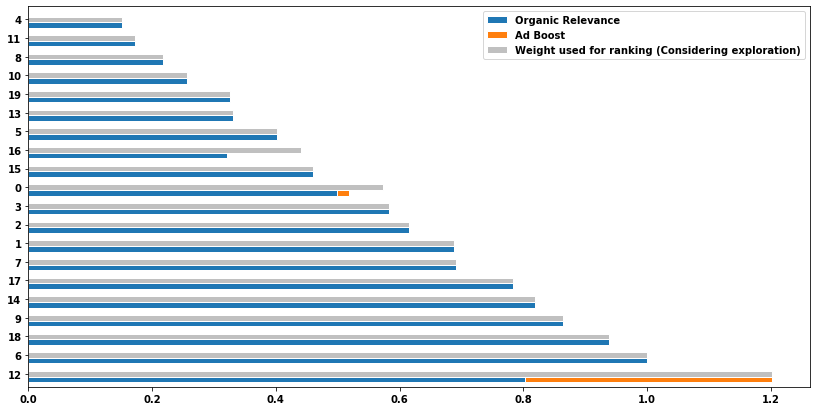



Results after 800 iterations -------


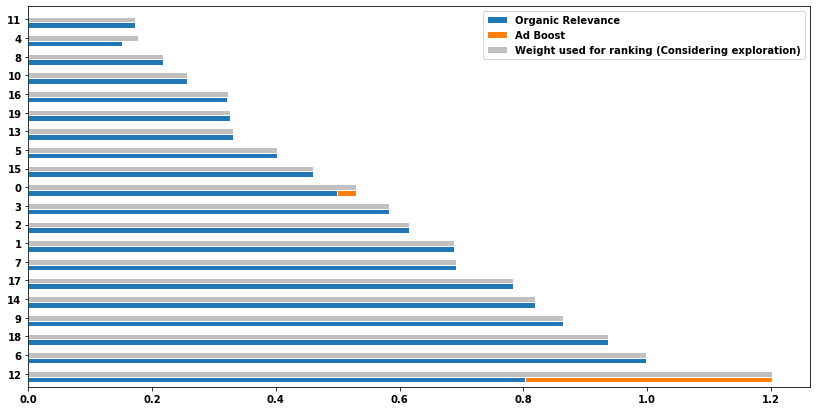



Results after 900 iterations -------


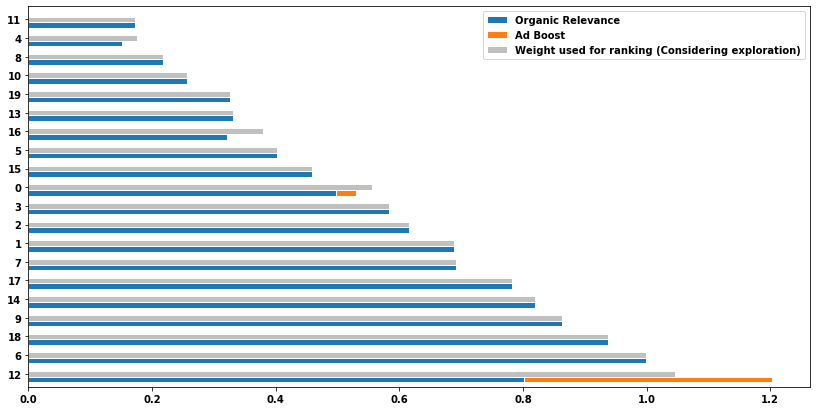



Results after 1000 iterations -------


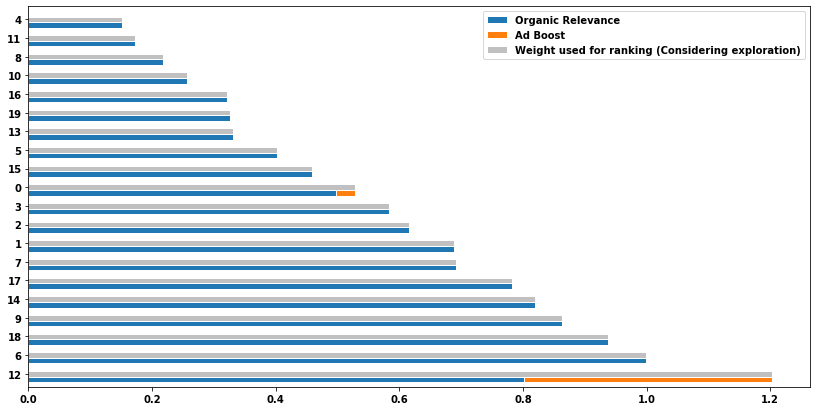



Results after 1100 iterations -------


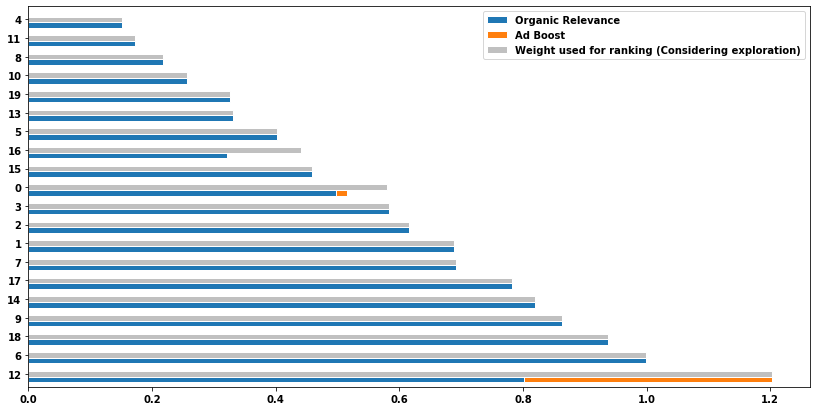



Results after 1200 iterations -------


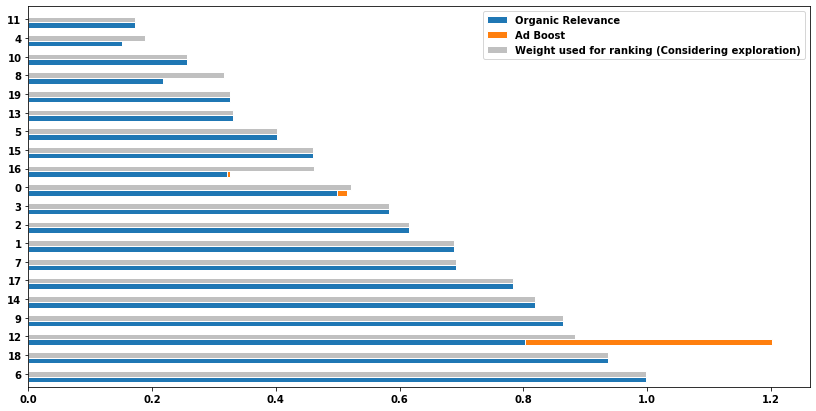



Results after 1300 iterations -------


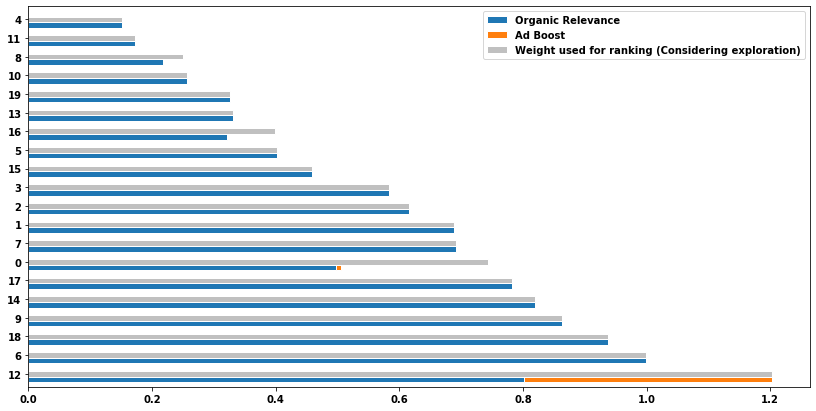



Results after 1400 iterations -------


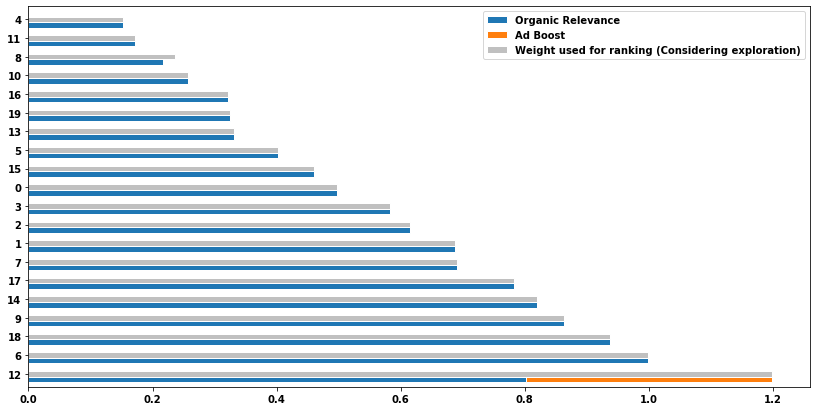



Results after 1500 iterations -------


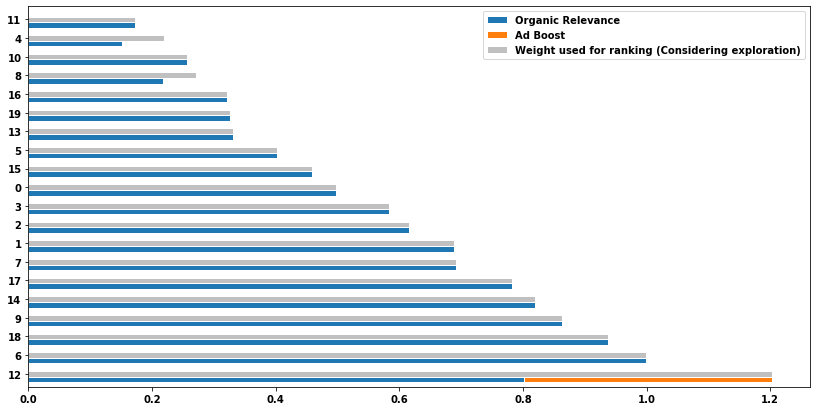



Results after 1600 iterations -------


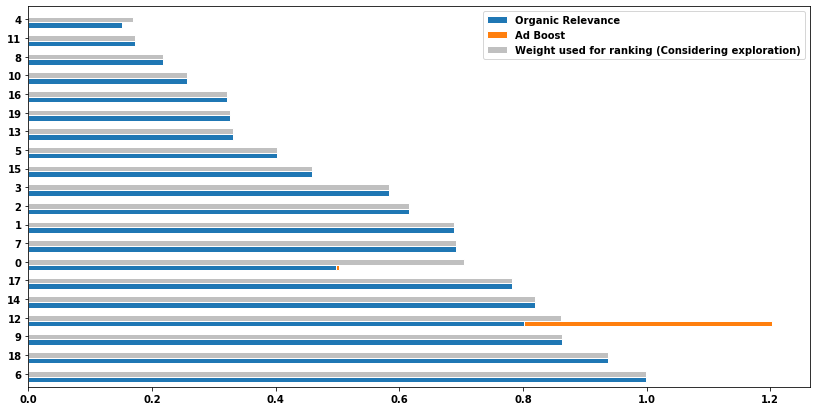



Results after 1700 iterations -------


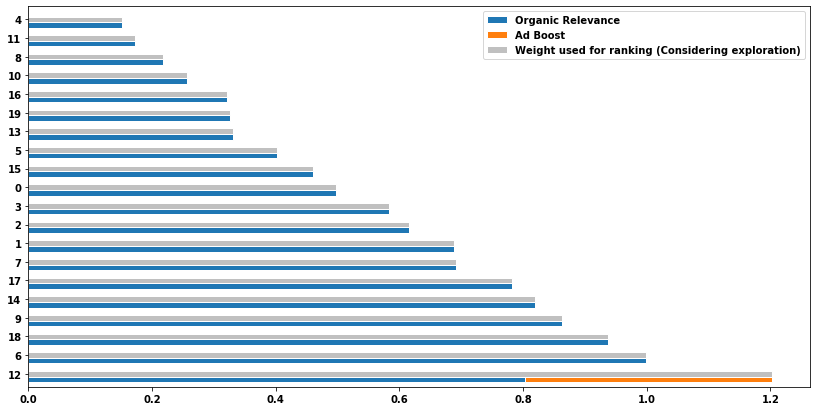



Results after 1800 iterations -------


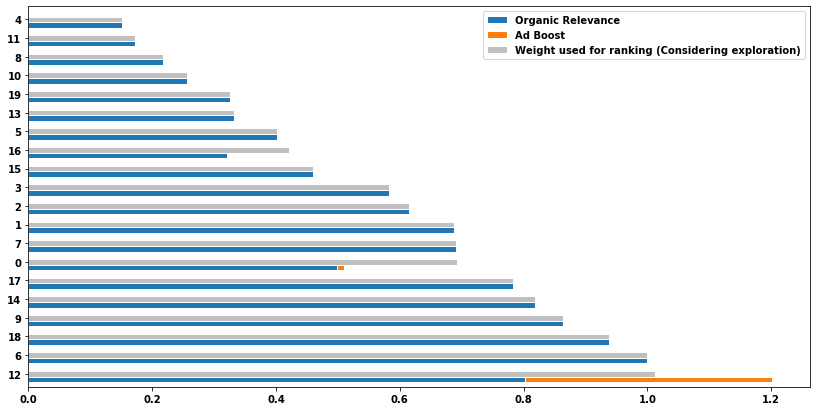



Results after 1900 iterations -------


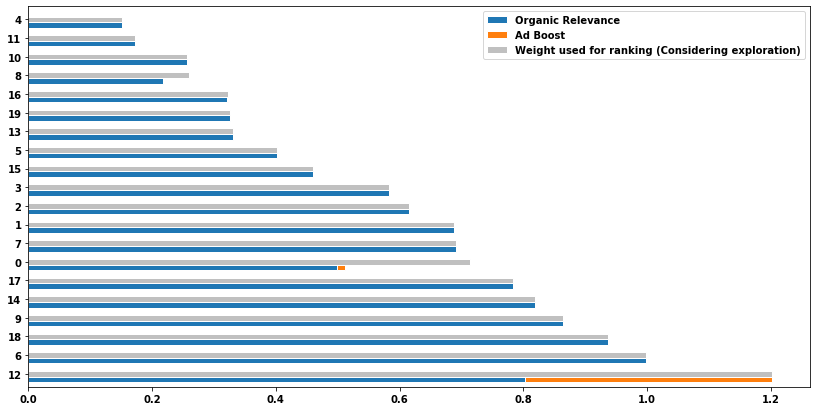



Results after 2000 iterations -------


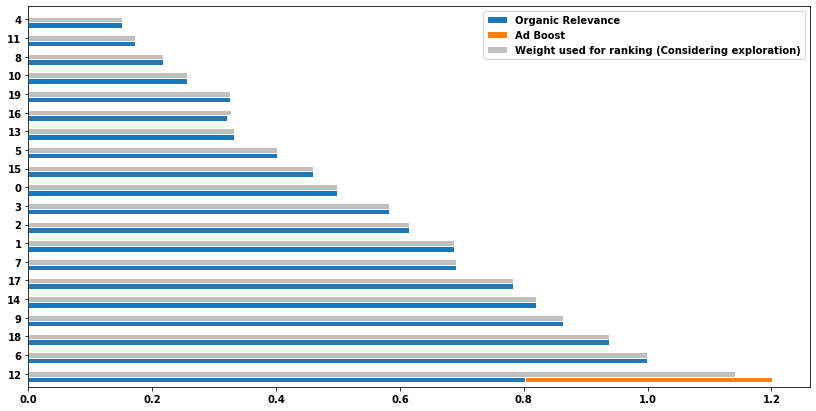

In [13]:
num_episodes = 2000
for i in range(num_episodes):
    simulate_clicks(sr)
    if(i % 100 == 99):
        print("\n\nResults after {} iterations -------".format(i + 1))
        printresults(sr.get_results_with_ads())